In [0]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import cPickle as pickle
import tensorflow as tf
%matplotlib inline

In [0]:
from tensorflow.keras.applications.vgg19 import VGG19

In [0]:
class CONFIG:
    IMAGE_WIDTH = 400
    IMAGE_HEIGHT = 300
    COLOR_CHANNELS = 3
    NOISE_RATIO = 0.6
    MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 

In [0]:
def load_vgg_model():
    """
    Returns a model for the purpose of 'painting' the picture.
    Takes only the convolution layer weights and wrap using the TensorFlow
    Conv2d, Relu and AveragePooling layer. VGG actually uses maxpool but
    the paper indicates that using AveragePooling yields better results.
    The last few fully connected layers are not used.
    Here is the detailed configuration of the VGG model:
        0 is conv1_1 (3, 3, 3, 64)
        1 is relu
        2 is conv1_2 (3, 3, 64, 64)
        3 is relu    
        4 is maxpool
        5 is conv2_1 (3, 3, 64, 128)
        6 is relu
        7 is conv2_2 (3, 3, 128, 128)
        8 is relu
        9 is maxpool
        10 is conv3_1 (3, 3, 128, 256)
        11 is relu
        12 is conv3_2 (3, 3, 256, 256)
        13 is relu
        14 is conv3_3 (3, 3, 256, 256)
        15 is relu
        16 is conv3_4 (3, 3, 256, 256)
        17 is relu
        18 is maxpool
        19 is conv4_1 (3, 3, 256, 512)
        20 is relu
        21 is conv4_2 (3, 3, 512, 512)
        22 is relu
        23 is conv4_3 (3, 3, 512, 512)
        24 is relu
        25 is conv4_4 (3, 3, 512, 512)
        26 is relu
        27 is maxpool
        28 is conv5_1 (3, 3, 512, 512)
        29 is relu
        30 is conv5_2 (3, 3, 512, 512)
        31 is relu
        32 is conv5_3 (3, 3, 512, 512)
        33 is relu
        34 is conv5_4 (3, 3, 512, 512)
        35 is relu
        36 is maxpool
        37 is fullyconnected (7, 7, 512, 4096)
        38 is relu
        39 is fullyconnected (1, 1, 4096, 4096)
        40 is relu
        41 is fullyconnected (1, 1, 4096, 1000)
        42 is softmax
    """
    weights={}
    with open('data.p', 'rb') as fp:
        weights = pickle.load(fp)
    
    def _weights(expected_layer_name):
        """
        Return the weights and bias from the VGG model for a given layer.
        """
        W=weights[expected_layer_name]
    
        return W

    def _relu(conv2d_layer):
        """
        Return the RELU function wrapped over a TensorFlow layer. Expects a
        Conv2d layer input.
        """
        return tf.nn.relu(conv2d_layer)

    def _conv2d(prev_layer,layer_name):
        """
        Return the Conv2D layer using the weights, biases from the VGG
        model at 'layer'.
        """
        W= _weights(layer_name+'/kernel:0')
        b= _weights(layer_name+'/bias:0')
        W = tf.constant(W)
        b = tf.constant(np.reshape(b, (b.size)))
        return tf.nn.conv2d(prev_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b

    def _conv2d_relu(prev_layer, layer_name):
        """
        Return the Conv2D + RELU layer using the weights, biases from the VGG
        model at 'layer'.
        """
        return _relu(_conv2d(prev_layer, layer_name))

    def _avgpool(prev_layer):
        """
        Return the AveragePooling layer.
        """
        return tf.nn.max_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Constructs the graph model.

    graph = {}
    graph['input']   = tf.Variable(np.zeros((1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS)), dtype = 'float32')
    graph['conv1_1']  = _conv2d_relu(graph['input'],'block1_conv1')
    graph['conv1_2']  = _conv2d_relu(graph['conv1_1'],'block1_conv2')
    graph['avgpool1'] = _avgpool(graph['conv1_2'])
    graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 'block2_conv1')
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 'block2_conv2')
    graph['avgpool2'] = _avgpool(graph['conv2_2'])
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'],'block3_conv1')
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 'block3_conv2')
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'],  'block3_conv3')
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 'block3_conv4')
    graph['avgpool3'] = _avgpool(graph['conv3_4'])
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 'block4_conv1')
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'],  'block4_conv2')
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 'block4_conv3')
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 'block4_conv4')
    graph['avgpool4'] = _avgpool(graph['conv4_4'])
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 'block5_conv1')
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'],'block5_conv2')
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'],  'block5_conv3')
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 'block5_conv4')
    graph['avgpool5'] = _avgpool(graph['conv5_4'])
    
    return graph


In [0]:
# GRADED FUNCTION: compute_content_cost

def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    m, n_H, n_W, n_C = a_G.shape
    
    # Reshape a_C and a_G
    a_C_unrolled =  tf.reshape(tensor=a_C,shape=[int(m),int(n_H*n_W),int(n_C)],name="a_C_unrolled")
    a_G_unrolled =  tf.reshape(tensor=a_G,shape=[int(m),int(n_H*n_W),int(n_C)])

    # compute the cost with tensorflow
    J_content = tf.divide(x=tf.reduce_sum(tf.square( tf.subtract( a_C_unrolled, a_G_unrolled) ), [-1,0,1]),
                          y=4*int(n_H)*int(n_W)*int(n_C))
    
    return J_content

In [0]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    
    GA = tf.matmul(A,tf.transpose(A))
    
    return GA

In [0]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # Retrieve dimensions from a_G 
    m, n_H, n_W, n_C = a_G.shape
    
    # Reshape the images to have them of shape (n_C, n_H*n_W) 
    a_S = tf.reshape(tensor=a_S,shape=[int(n_H*n_W),int(n_C)])
    a_S=tf.transpose(a_S)
    a_G = tf.reshape(tensor=a_G,shape=[int(n_H*n_W),int(n_C)])
    a_G=tf.transpose(a_G)

    # Computing gram_matrices for both images S and G 
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss 
    J_style_layer = tf.divide(x=tf.reduce_sum(tf.square( tf.subtract( GS, GG) )),
                          y=tf.square(float(2*int(n_H)*int(n_W)*int(n_C))))
    

    
    return J_style_layer

In [0]:
STYLE_LAYERS = [('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [0]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers

    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

In [0]:
def tv_loss_func(model):
    return tf.reduce_sum(tf.image.total_variation(model['input']))

In [0]:
def generate_noise_image(content_image, noise_ratio = CONFIG.NOISE_RATIO):
    """
    Generates a noisy image by adding random noise to the content_image
    """
    
    # Generate a random noise_image
    noise_image = np.random.uniform(-20, 20, (1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS)).astype('float32')
    
    # Set the input_image to be a weighted average of the content_image and a noise_image
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    
    return noise_image



def reshape_and_normalize_image(image):
    """
    Reshape and normalize the input image (content or style)
    """
    image = image[...,::-1]
    # Reshape image to mach expected input of VGG16
    image = np.reshape(image, ((1,) + image.shape))
    
    # Substract the mean to match the expected input of VGG16
    image = image - CONFIG.MEANS
    
    return image


def save_image(path, image):
    
    # Un-normalize the image so that it looks good
    image = image + CONFIG.MEANS
    
    # Clip and Save the image
    image = np.clip(image[0], 0, 255).astype('uint8')
    image = image[...,::-1]
    scipy.misc.imsave(path, image)

In [0]:
# GRADED FUNCTION: total_cost

def total_cost(J_content, J_style,total_variation_loss, alpha, beta,gamma):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.  +(gamma*total_variation_loss)
    """
    
    J = (alpha*J_content)+(beta*J_style)+(gamma*total_variation_loss)
    
    return J

In [0]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

In [ ]:
content_image = scipy.misc.imread("tubGermany.jpg")

In [0]:
print(content_image.shape)
content_image = reshape_and_normalize_image(content_image)
print(content_image.shape)

(279, 480, 3)
(1, 279, 480, 3)


In [ ]:
style_image = scipy.misc.imread("Images/StarryNight.jpg")

In [0]:
print(style_image.shape)
style_image = reshape_and_normalize_image(style_image)
print(style_image.shape)

(279, 480, 3)
(1, 279, 480, 3)


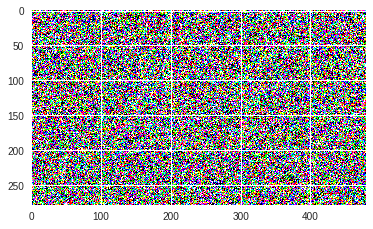

In [0]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

In [0]:
model = load_vgg_model()

In [0]:
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

In [0]:
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

In [0]:
sess.run(model['input'].assign(generated_image))
variation_loss=tv_loss_func(model)

In [0]:
J = total_cost(J_content, J_style,variation_loss, alpha = 10.0, beta = 100.0,gamma=0.001)

In [0]:
#Here, Lbfgs optimiser is used. To use Adam Optimiser remove the comment below.
optimizer = tf.contrib.opt.ScipyOptimizerInterface(
    J, method='L-BFGS-B',
      options={'maxiter': num_iterations,
                  'disp': 100})

#optimizer = tf.train.AdamOptimizer(3.0)
#train_step = optimizer.minimize(J)

In [0]:
#Number of training iterations
num_iterations=1000

In [0]:
#NST model with Adam Optimiser
def model_nn(sess, input_image, num_iterations = 601):
    
    # Initialize global variables (you need to run the session on the initializer)
    sess.run(tf.global_variables_initializer())
    
    # Run the noisy input image (initial generated image) through the model. Use assign().
    sess.run(model['input'].assign(input_image))
    
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
        sess.run(train_step)
        
        # Compute the generated image by running the session on the current model['input']
        generated_image = sess.run(model['input'])

        # Print every 100 iteration.
        if i%100 == 0:
            Jt, Jc, Js,Jtv = sess.run([J, J_content, J_style, variation_loss])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            print("total variation loss cost = " + str(Jtv))
            # save current generated image in the "/output" directory
            save_image("Images/" + str(i) + ".png", generated_image)
    
    # save last generated image
    save_image('Images/generated_image.jpg', generated_image)
    
    return generated_image

In [0]:
#NST model with lbgfs Optimiser
def model_lbfgs(sess,input_image,num_iterations=1000):
    sess.run(tf.global_variables_initializer())
    optimizer.minimize(sess)
    generated_image = sess.run(model['input'])
    save_image('Images/generated_image.jpg', generated_image)

In [0]:
model_nn(sess, generated_image)

In [ ]:
model_lbfgs(sess,generated_image)